# Bayesian NMF

We will try to set up a MF workflow for the AMS data for Krakow, first we define our matrix factorization model, coming from the PyMC documentation. Notice that here `PMF` refers to Probabilistic Matrix Factorization instead of Positive Matrix Factorization as known in the air quality literature

In [1]:
import logging
import time

import scipy as sp
import theano
import pandas as pd
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


## Data loading

We load the original Krakow data in format itx, we resample at different resolutions

In [4]:
from src.python.aurora_py.itx_adapter import ItxAdapter

with open("../data/observations/KRK_input_10min.itx","r") as file:
    itx_adapter = ItxAdapter(file.read())

krakow_df = itx_adapter.to_pandas()
krakow_df.drop([12.0,37.0],axis=1,inplace=True)

krakow_df_30min = krakow_df.resample("30min").mean()
krakow_df_1h = krakow_df.resample("1H").mean()
krakow_df_1d = krakow_df.resample("1D").mean()

## Non-negative matrix factorization model


In [3]:
# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
            U = PositiveNormal(
                "U",
                mu=0,
                tau=self.alpha_u,
                shape=(n, dim)
            )
            V = PositiveNormal(
                "V",
                mu=0,
                tau=self.alpha_v,
                shape=(m, dim)
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )


        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

    def _find_map(self):
        """Find mode of posterior using L-BFGS-B optimization."""
        tstart = time.time()
        with self.model:
            logging.info("finding PMF MAP using L-BFGS-B optimization...")
            self._map = pm.find_MAP(method="L-BFGS-B")

        elapsed = int(time.time() - tstart)
        logging.info("found PMF MAP in %d seconds" % elapsed)
        return self._map

    @property
    def map(self):
        try:
            return self._map
        except:
            return self._find_map()

    # Draw MCMC samples.
    def _draw_samples(self):
        with self.model:
            self._trace = pm.sample(chains=4)

    @property
    def trace(self):
        try:
            return self._trace
        except:
            return self._draw_samples()


    def _posterior_predicive(self):
        with self.model:
            self._ppc = pm.sample_posterior_predictive(self.trace, var_names=["R"])

    @property
    def ppc(self):
        return self._ppc

# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE




In [ ]:
    
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 8

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 11


pmf = PMF(krakow_df_1d.values, DIM, ALPHA, std=0.05)

# Find MAP for PMF
trace = pmf.trace;

INFO:root:building the PMF model
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpalahb7jj
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpi8pik5pq
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpk1tgi9q9
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpsvvx2fz2
INFO:root:done building the PMF model
/var/folders/dm/b79x42n96dl9s8jpb4t3_9lc0000gp/T/ipykernel_73558/612420354.py:88: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be 

In [62]:
ppc = pmf.ppc(1)

<AxesSubplot:xlabel='R'>

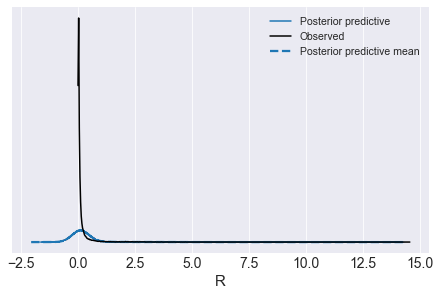

In [64]:
import arviz as az
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pmf.model))